<a href="https://colab.research.google.com/github/mlnbk/neural_networks/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end Multi-class Dog Breed Classification

This notebook builds a multi-class image classifier using TensoFlow 2 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.


## 2. Data

The data being used is from Kaggle's dog breed identification competition.
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

For each image in the test set, we must predict a probability for each of the different breeds.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

* Images (unstructured data) -> deep learning/transfer learning should be used
* There are 120 dog breeds (120 different classes)
* 10000+ images in the training set (labeled)
* 10000+ images in the test set (unlabeled, it should be predicted)

In [ ]:
# Unzip the uploaded data in Google Drive
!unzip -qq "/content/drive/MyDrive/Colab Data/Dog Vision/dog-breed-identification.zip" -d "/content/drive/MyDrive/Colab Data/Dog Vision/"

### Setup workspace

* Import TensorFlow 2.X
* Import TensorFlow Hub
* Make sure GPU is used

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU availability
print('GPU', 'available' if tf.config.list_physical_devices('GPU') else 'not available')

GPU available


# 1. Data

For all machine learning models, the data has to be in numerical format.

In [30]:
labels_csv = pd.read_csv('drive/MyDrive/Colab Data/Dog Vision/labels.csv')
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [31]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

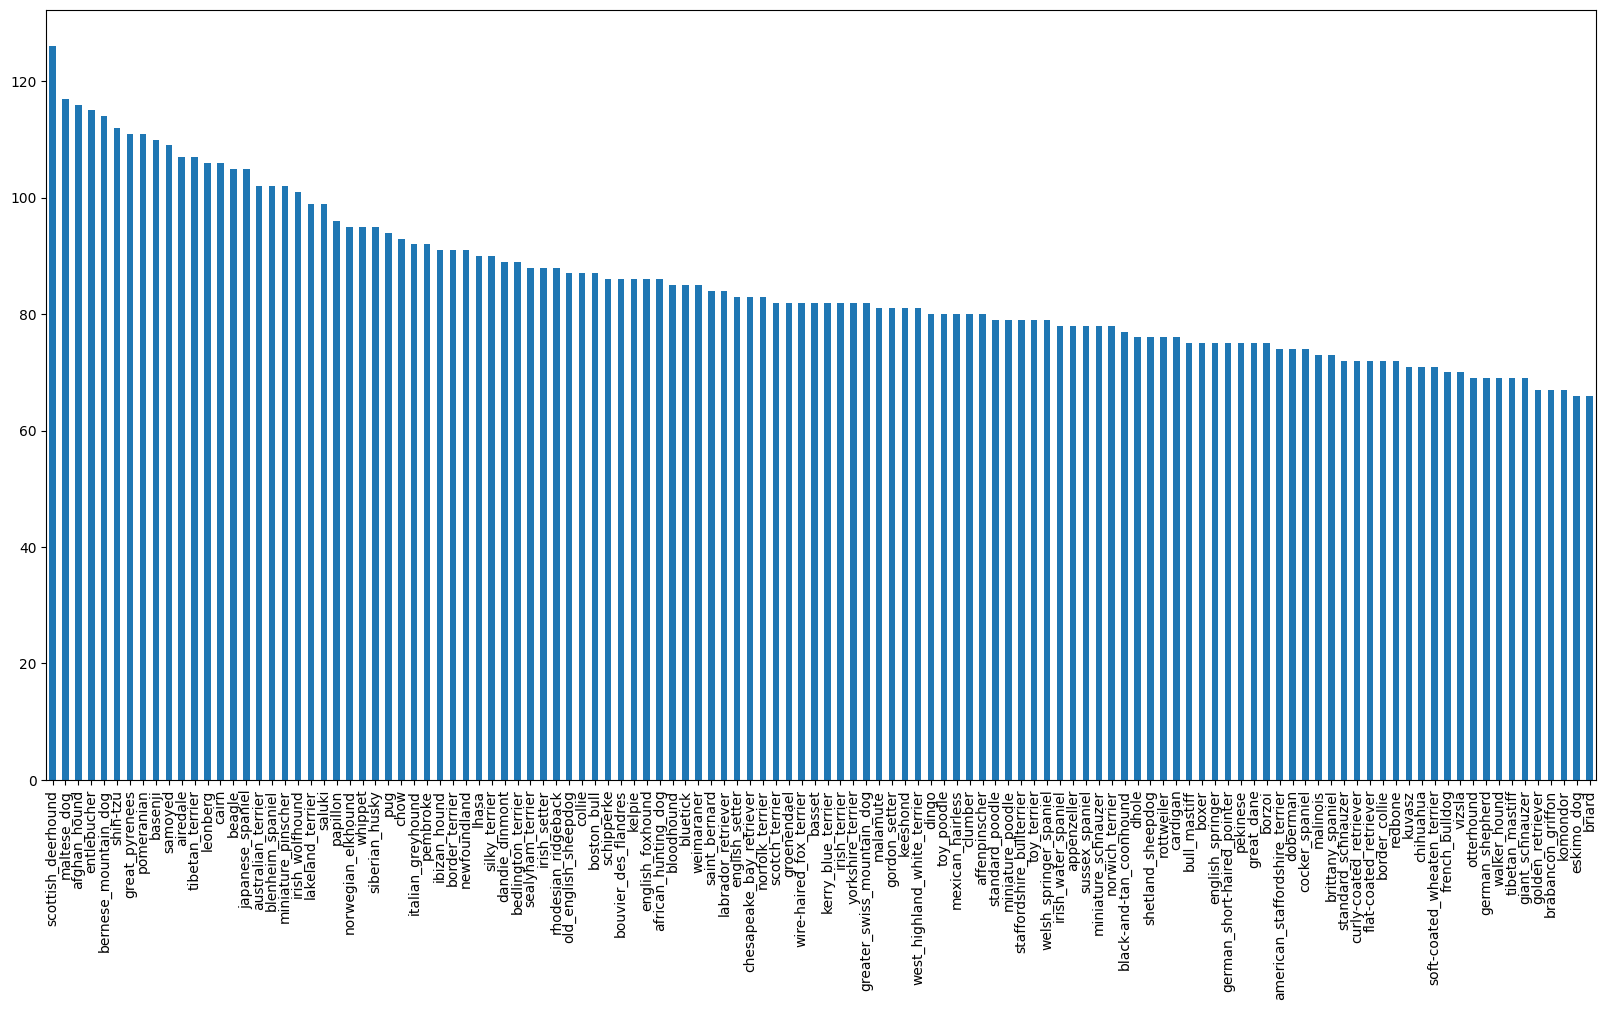

In [32]:
# Number of images for each breed

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [33]:
labels_csv['breed'].value_counts().median()

82.0

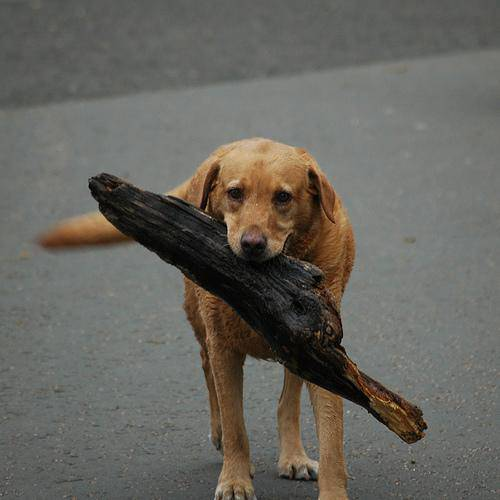

In [34]:
# Viewing an image
from IPython.display import Image
Image('drive/MyDrive/Colab Data/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg')

### Getting images and their labels

In [35]:
# list all image file paths
filepaths = [f'drive/MyDrive/Colab Data/Dog Vision/train/{fname}.jpg' for fname in labels_csv['id']]

In [36]:
# check if number of filenames matches the actual number of image files
import os

if len(os.listdir('drive/MyDrive/Colab Data/Dog Vision/train')) == len(filepaths):
  print('Filenames match actual amount of files.')
else:
  print('Filenames do not match actual amount of files, check the target directory.')

Filenames match actual amount of files.


## Turn labels into numerical values

In [37]:
labels = labels_csv['breed'].to_numpy()

In [38]:
# find unique labels

unique_breeds = np.unique(labels)

In [39]:
# turn every label into a boolean array

boolean_labels = [label == unique_breeds for label in labels]

In [40]:
# turn boolean array to integers

print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating the validation set

In [41]:
# setup X and y variables
X = filepaths
y = boolean_labels

In [42]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [43]:
from sklearn.model_selection import train_test_split

# split them into training and validation using NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Preprocessing images (turning into Tensors)

To preprocess the images into Tensors a following function will be implemented:

1. takes an image filename as input
2. uses TensorFlow to read the file and save it to a variable, image
3. turn image (a jpeg file) into Tensors
4. resize the image to be of shape (224, 224).
5. return the modified image

In [44]:
# convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filepaths[42]) # read in an image
image.shape

(257, 350, 3)

In [45]:
# convert to Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [46]:
# define image size
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
  '''
  Takes an image file path and turns it into a Tensor.
  '''
  # read an image file
  image = tf.io.read_file(image_path)

  # turn the jpeg image into numerical Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  # convert the color channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # resize the image (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Creating data batches

Batch:
* small portion of your data, (32 is generally the default batch size) images and their labels
  * in deep learning, instead of finding patterns in an entire dataset at the same time, we find them one batch at a time

In [47]:
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  '''
  image = process_image(image_path)
  return image, label

In [48]:
BATCH_SIZE = 32 # good default

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  '''
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  '''

  # if test dataset, no labels
  if test_data:
    print('Creating test data batches...')

    # turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths
    return data.map(process_image).batch(BATCH_SIZE)

  # if valid dataset, no need to shuffle it ()
  elif valid_data:
    print('Creating validation data batches...')

    # turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    return data.map(get_image_label).batch(BATCH_SIZE)

  # if training dataset, we shuffle it
  else:
    print('Creating training data batches...')

    # turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels

    # shuffling pathnames and labels is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    return data.map(get_image_label).batch(BATCH_SIZE)

In [49]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [50]:
# check out the different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [51]:
def show_n_images(images, labels, n=25):
  '''
  Displays `n` images from a data batch.
  Default value of `n` is 25.
  '''

  r = n if n < len(images) else len(images)

  plt.figure(figsize=(10, 10))

  for i in range(r):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis('off')

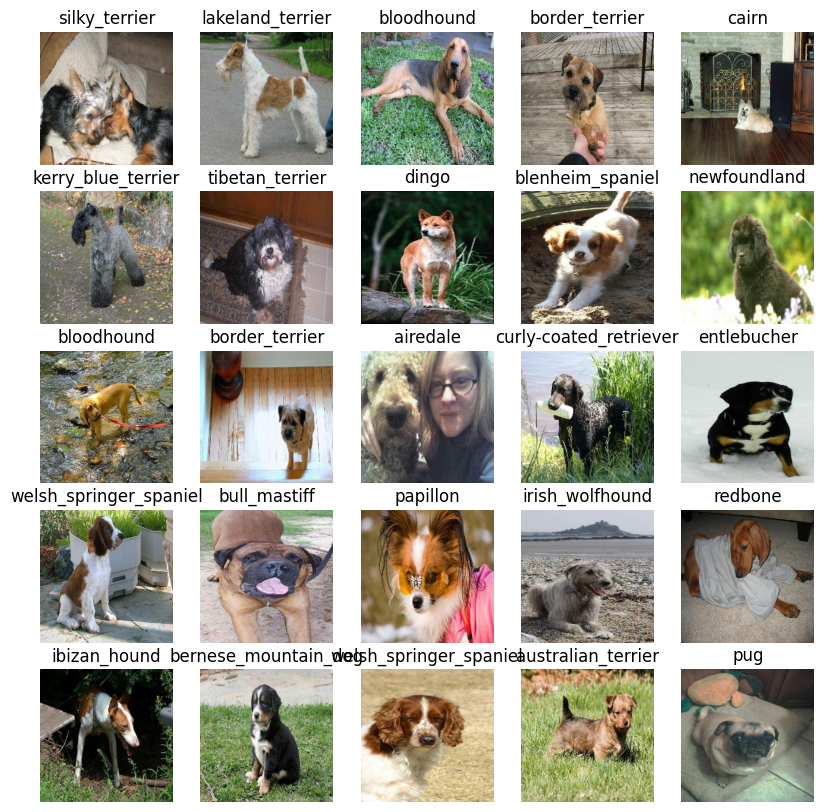

In [52]:
# show training images from the training data batch

train_images, train_labels = next(train_data.as_numpy_iterator())
show_n_images(train_images, train_labels)


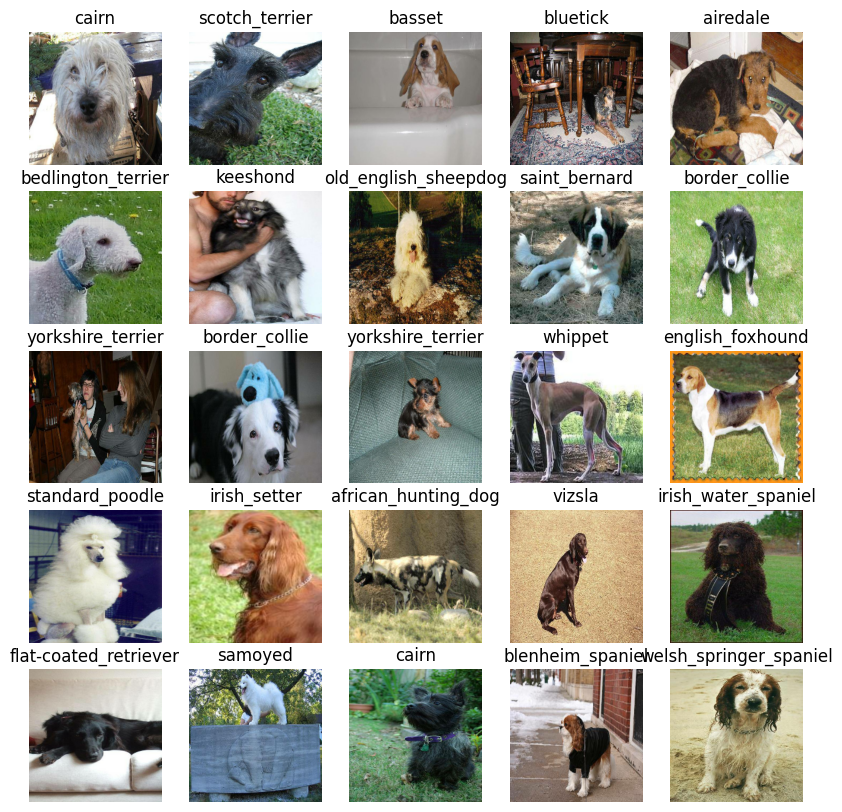

In [53]:
# show validation images from the validation data batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_n_images(val_images, val_labels)

# Creating and training a model

Transfer learning:
* using pre-trained model for a new problem
* models can be find through TensorFlow Hub

**Why pre-trained model?**
* Building a machine learning model and training it from scratch can be expensive and time consuming
* Using an existing model and tuning it to accomodate the problem we try to solve improves this process

**How to choose a model?**
* Know the problem (i.e. image classification) and search on TensorFlow Hub page accordingly

## Building a model

Things to define:
* input shape (images, in the form of Tensors)
* output shape (image labels, in the form of Tensors)
* URL of the model

In [54]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

OUTPUT_SHAPE = len(unique_breeds) # number of unique labels

MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Best way to build models: [Keras API](https://www.tensorflow.org/guide/keras/overview)
* straight-forward: "here are the layers of the model, the input shape and the output shape, let's go!"

### Setting up the model layers

2 ways:
1. Functional for more complex models
2. Sequential (linear stack of layers) for less complex models

**Layer 1:**
* the actual model being used from TF Hub (`hub.KerasLayer(MODEL_URL)`)
  * takes the images and finds patterns in them based on the patterns `mobilenet_v2_130_224` has found

**Layer 2:**
* output layer (`tf.keras.layers.Dense()`)
  * takes the information form the previous layer and outputs it in the desired output shape
  * `activation='softmax'`: assign a probability value to each label (betwwen 0 and 1)
    * for binary classification: `activation='sigmoid'`

### Compiling the layers

* `loss` - the models goal is to minimize this, getting to 0
* `optimizer` - it lowers the loss function based on what it did so far. The `Adam` optimizer is a great general which performs well on most models. Other optimizers include `RMSprop` and `Stochastic Gradient Descent`
* `metrics` - rates the perfomance, in this case, giving the accuracy of how well the model is predicting the correct image label

### Building the model

* `model.build()` tell the input shape to the model
  * this case: `[batch_size, img_height, img_width, color_channels]`
  * batch size is left as None as this is inferred from the data passed to the model


In [56]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  '''
  Takes the input shape, output shape and the model's URL as parameters.
  Defines the layers in a Keras model sequentially.
  Compiles the model (says how it should be evaluated and improved).
  Builds the model (tells it what kind of input shape it'll be getting).
  Returns the model.
  '''
  print("Building model with:", MODEL_URL)

  # setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation='softmax') # layer 2 (output layer)
  ])

  # compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # the model should reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # tells the model how to improve its guesses
      metrics=['accuracy'] # this should be improved
  )

  model.build(INPUT_SHAPE) # let the model know what kind of inputs it'll be getting

  return model

In [57]:
# create a model and check its details
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


* **Non-trainable parameters:** patterns learned by `mobilenet_v2_130_224`
* **Trainable parameters:** they are in the dense layer (what we added)

***Takeaway:*** the main bulk of the information in the model has already been learned and we're going to take that and adapt it to our own problem